This notebook uses widgets for you to easily enter the values corresponding to your AEP instance. You should be able to find all the values required above by following the `Setup` section of the **README**.

If you are running this notebook on Databricks, the next couple cells will initialize the widgets and retrieve the values used throughout this notebook.

If you are not running this notebook on Databricks and instead are running it locally or another environment, the next couple cells will be looking for your configuration file containing the values used throughout this notebook. See more details in the `Setup` section of the **README** to understand how to create your configuration file.

In [0]:
import os

if "DATABRICKS_RUNTIME_VERSION" in os.environ:
  dbutils.widgets.text("imsOrgId", "", label="IMS Org ID")
  dbutils.widgets.text("sandboxName", "", label="Sandbox name")
  dbutils.widgets.text("privateKeyPath", "", label="Private Key Path")
  dbutils.widgets.text("clientId", "", label="Client ID")
  dbutils.widgets.text("clientSecret", "", label="Client Secret")
  dbutils.widgets.text("techAccountId", "", label="Technical Account ID")
  dbutils.widgets.text("datasetId", "", label="Dataset ID")

In [0]:
import os

if "DATABRICKS_RUNTIME_VERSION" in os.environ:
  ims_org_id = dbutils.widgets.get("imsOrgId")
  sandbox_name = dbutils.widgets.get("sandboxName")
  client_id = dbutils.widgets.get("clientId")
  client_secret = dbutils.widgets.get("clientSecret")
  private_key_path = dbutils.widgets.get("privateKeyPath")
  tech_account_id = dbutils.widgets.get("techAccountId")
  dataset_id = dbutils.widgets.get("datasetId")
elif "ADOBE_HOME" in os.environ:
  from configparser import ConfigParser
  
  config = ConfigParser()
  config_path = os.path.join(os.environ["ADOBE_HOME"], "conf", "config.ini")
  if not os.path.exists(config_path):
    raise Exception(f"Looking for configuration under {config_path} but config not found, please verify path")
  config.read(config_path)
  
  ims_org_id = config.get("Platform", "ims_org_id")
  sandbox_name = config.get("Platform", "sandbox_name")
  client_id = config.get("Authentication", "client_id")
  client_secret = config.get("Authentication", "client_secret")
  private_key_path = config.get("Authentication", "private_key_path")
  tech_account_id = config.get("Authentication", "tech_acct_id")
  dataset_id = config.get("Platform", "dataset_id")
else:
  raise Exception("Either DATABRICKS_RUNTIME_VERSION or ADOBE_HOME needs to be specified")
  
if not os.path.exists(private_key_path):
  raise Exception(f"Looking for private key file under {private_key_path} but key not found, please verify path")

In [0]:
import re

username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
unique_id = s = re.sub("[^0-9a-zA-Z]+", "_", username)

print(f"Username: {username}")
print(f"Unique ID: {unique_id}")

Username: cmenguy@adobe.com
Unique ID: cmenguy_adobe_com


Before we run anything, make sure to install the following required libraries for this notebook. They are all publicly available libraries and the latest version should work fine.

In [0]:
!pip install mmh3
!pip install rstr
!pip install aepp
!pip install pygresql

     |████████████████████████████████| 49 kB 2.4 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-cbb4570d-2046-4bfd-a25d-82845c8fb7d1/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-cbb4570d-2046-4bfd-a25d-82845c8fb7d1/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 106 kB 11.2 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-cbb4570d-2046-4bfd-a25d-82845c8fb7d1/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 270 kB 11.5 MB/s 
  Created wheel for pygresql: filename=PyGreSQL-5.2.4-cp39-cp39-linux_x86_64.whl size=190681 sha256=6c6c618dcd0a755d0d081df0968590983c564bcd74f477f334572d01a3c80a93
  Stored in directory: /root/.cache/pip/wheels/92/7e/23/4aa8a1c99ea0229b774f0f31dade31ed9199fdae0f15b7edbb
Successfully built pygresql
You should consider u

This notebook will show the full experience of using AEP data in your own Databricks instance.

**If you already have a dataset in AEP you want to use, please skip part 1 and start with part 2 directly and enter your dataset ID in the top widget**

# Part 1: Generating Synthetic Data

## 1.a: Setting up Synthetic Schema and Dataset

We'll be using the [aepp Python library](https://github.com/pitchmuc/aepp) here to interact with AEP APIs and create a schema and dataset suitable for adding our synthetic data further down the line. This library simply provides a programmatic interface around the REST APIs, but all these steps could be completed similarly using the raw APIs directly or even in the UI. For more information on the underlying APIs please see [the API reference guide](https://developer.adobe.com/experience-platform-apis/).

Before any calls can take place, we need to configure the library and setup authentication credentials. For this you'll need the following piece of information. For information about how you can get these, please refer to the `Setup` section of the **Readme**:
- Client ID
- Client secret
- Private key
- Technical account ID

The private key needs to be accessible on disk from this notebook. We recommend uploading it to DBFS and refering to it with the `/dbfs` prefix. This can be achieved by clicking in the Databricks notebook interface on `File > Upload data to DBFS` and then selecting the **private.key** file you downloaded during the setup, click `Next` and then you should have the option to copy the path. Make sure it starts with `/dbfs/FileStore` - for example if you uploaded your private key into `/FileStore/shared_upload/your_username` then the final path should be `/dbfs/FileStore/shared_uploads/your_username/private.key`. Copy that value into the cell `Private Key Path` at the very top of this notebook.

In [0]:
import aepp

aepp.configure(
  org_id=ims_org_id,
  tech_id=tech_account_id, 
  secret=client_secret,
  path_to_key=private_key_path,
  client_id=client_id
)

First we need to create the schema to support our synthetic data. We need a few fields which will be included in the synthetic data:
- Direct Marketing information
- Web details
- Identity information

These are already provided in your AEP instance as default field groups, so we'll be leveraging that for creation below.

In [0]:
from aepp import schema

schema_conn = schema.Schema()

schema_conn.sandbox

Out[6]: 'prod'

In [0]:
schema_res = schema_conn.createExperienceEventSchema(
  name=f"[CMLE] Synthetic Event Schema (created by {username})",
  mixinIds=[
    "https://ns.adobe.com/xdm/context/experienceevent-directmarketing",
    "https://ns.adobe.com/xdm/context/identitymap",
    "https://ns.adobe.com/xdm/context/experienceevent-web"
  ],
  description="Schema generated by CMLE for synthetic events",
)

schema_id = schema_res["$id"]
schema_id

Out[7]: 'https://ns.adobe.com/adobecorerealtimecdpprod/schemas/6e9d9c4e49dac1b8ab2d7d0ae51ddfecf7b7dea74a3ea650'

Note the schema ID printed in the previous cell. This will need to be provided when creating the dataset in the next step so we can tie that dataset back to the kind of data we expect.

In [0]:
from aepp import catalog

cat_conn = catalog.Catalog()

In [0]:
dataset_res = cat_conn.createDataSets(
  name=f"[CMLE] Synthetic Event Dataset (created by {username})",
  schemaId=schema_id
)

dataset_id = dataset_res[0].split("/")[-1]
dataset_id

Out[9]: '63dd7bcec086321c06577da2'

The dataset ID printed above is where we will be uploading all the synthetic data, and what we will use as the basis for querying the data and building our ML model down the line. You can save it in the top widget of this notebook named `Dataset ID` so that you don't need to recreate it if you run this notebook again later.

## 1.b: Generating Synthetic Data

In [0]:
import random, string
import uuid
from datetime import datetime, timedelta
import mmh3
import rstr
from random import randrange

In [0]:
advertising_events = {
 
    #eventType          : (weeklyAverageOccurrence, propensityDelta, [(field_to_replace, value)], timeInHoursFromDependent)
    "advertising.clicks": (0.01,                    0.002,            [("advertising/clicks/value", 1.0)], 0.5) , 
    "advertising.impressions": (0.1, 0.001, [("advertising/impressions/value", 1.0)], 0),

    "web.webpagedetails.pageViews": (0.1, 0.005, [("web/webPageDetails/pageViews/value", 1.0)], 0.1),
    "web.webinteraction.linkClicks": (0.05, 0.005, [("web/webInteraction/linkClicks/value", 1.0)], 0.1),
   
    
    "commerce.productViews": (0.05, 0.005, [("commerce/productViews/value", 1.0)], 0.2),
    "commerce.purchases": (0.01, 0.1, [("commerce/purchases/value", 1.0)], 1),
    
    
    "decisioning.propositionDisplay": (0.05, 0.005, [("_experience/decisioning/propositionEventType/display", 1)], 0.1),
    "decisioning.propositionInteract": (0.01, 0.1, [("_experience/decisioning/propositionEventType/interact", 1)], 0.05),
    "decisioning.propositionDismiss": (0.01, -0.2, [("_experience/decisioning/propositionEventType/dismiss", 1)], 0.05),

    
    "directMarketing.emailOpened": (0.2, 0.02, [("directMarketing/opens/value", 1.0)], 24),
    "directMarketing.emailClicked": (0.05, 0.1, [("directMarketing/clicks/value", 1.0)], 0.5),
    "directMarketing.emailSent": (0.5, 0.005, [("directMarketing/sends/value", 1.0)], 0),
    
    "web.formFilledOut": (0.0, 0.0, [("web/webPageDetails/name", "subscriptionForm")], 0),

}

event_dependencies = {
    "advertising.impressions": ["advertising.clicks"],
    "directMarketing.emailSent": ["directMarketing.emailOpened"],
    "directMarketing.emailOpened": ["directMarketing.emailClicked"],
    "directMarketing.emailClicked": ["web.webpagedetails.pageViews"],
    "web.webpagedetails.pageViews": ["web.webinteraction.linkClicks", "commerce.productViews", "decisioning.propositionDisplay"],
    "commerce.productViews": ["commerce.purchases"],
    "decisioning.propositionDisplay": ["decisioning.propositionInteract", "decisioning.propositionDismiss"]
    
}

In [0]:
import numpy as np
from datetime import datetime
import math


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

def create_data_for_n_users(n_users, first_user):
  
  N_USERS = n_users
  FIRST_USER = first_user
  
  N_WEEKS = 10
  GLOBAL_START_DATE = datetime.now() - timedelta(weeks=12)
  GLOBAL_END_DATE = GLOBAL_START_DATE + timedelta(weeks=N_WEEKS)

  events = []

  for user in range(N_USERS):
        user_id = FIRST_USER + user
        user_events = []
        base_events = {}
        for event_type in ["advertising.impressions", "web.webpagedetails.pageViews", "directMarketing.emailSent"]:
            n_events = np.random.poisson(advertising_events[event_type][0] * N_WEEKS)
            times = []
            for _ in range(n_events):
                #times.append(random_date(GLOBAL_START_DATE, GLOBAL_END_DATE)
                times.append(random_date(GLOBAL_START_DATE, GLOBAL_END_DATE).isoformat())

            base_events[event_type] = times

        for event_type, dependent_event_types in event_dependencies.items():

            if event_type in base_events:
                #for each originating event
                for event_time in base_events[event_type]:
                    #Look for possible later on events
                    for dependent_event in dependent_event_types:
                                n_events = np.random.poisson(advertising_events[dependent_event][0] * N_WEEKS)
                                times = []
                                for _ in range(n_events):
                                    #times.append(event_time + timedelta(hours = np.random.exponential(advertising_events[dependent_event][3])))
                                    new_time = datetime.fromisoformat(event_time) + timedelta(hours = np.random.exponential(advertising_events[dependent_event][3]))
                                    times.append(new_time.isoformat())
                                base_events[dependent_event] = times


        for event_type, times in base_events.items():
            for time in times:
                user_events.append({"userId": user_id, "eventType": event_type, "timestamp": time})

        user_events = sorted(user_events, key = lambda x: (x["userId"], x["timestamp"]))


        cumulative_probability = 0.001
        subscribed = False
        for event in user_events:
            cumulative_probability = min(1.0, max(cumulative_probability + advertising_events[event["eventType"]][1], 0))
            event["subscriptionPropensity"] = cumulative_probability
            if subscribed == False and "directMarketing" not in event["eventType"] and "advertising" not in event["eventType"]:
                subscribed = np.random.binomial(1, cumulative_probability) > 0
                if subscribed:
                    subscriptiontime = (datetime.fromisoformat(event["timestamp"]) + timedelta(seconds = 60)).isoformat()
                    #subscriptiontime = event["timestamp"] + timedelta(seconds = 60)
                    user_events.append({"userId": user_id, "eventType": "web.formFilledOut",  "timestamp": subscriptiontime})
            event["subscribed"] = subscribed
        user_events = sorted(user_events, key = lambda x: (x["userId"], x["timestamp"]))

        events = events + user_events
  return events

In [0]:
def normalize_ecid(ecid_part):
    ecid_part_str = str(abs(ecid_part))
    if len(ecid_part_str) != 19:
        ecid_part_str = "".join([str(x) for x in range(
            0, 19 - len(ecid_part_str))]) + ecid_part_str
    return ecid_part_str


def get_ecid(email):
    """
    The ECID must be two valid 19 digit longs concatenated together
    """
    ecidpart1, ecidpart2 = mmh3.hash64(email)
    ecid1, ecid2 = (normalize_ecid(ecidpart1), normalize_ecid(ecidpart2))
    return ecid1 + ecid2
  
def create_identity_map(email=None):
    nchars = random.randint(2,10)
    if email is None:
        email = ''.join(random.choices(string.ascii_letters + string.digits, k=nchars)) + "@adobe.com"
    ecid = get_ecid(email)        
    return {
            "ECID": [
                {
                    "id": f"{ecid}",
                    "primary": True
                }
            ],
            "email": [
                {
                    "id": f"{email}",
                    "primary": True
                }
            ]
        }

In [0]:
def create_email_event(user_id, event_type, timestamp):
  """
  Combines previous methods to creat various type of email events
  """
  
  if event_type == "directMarketing.emailSent":
    directMarketing = {"emailDelivered": {"value": 1.0}, 
                       "sends": {"value": 1.0}, 
                       "emailVisitorID": user_id,
                       "hashedEmail": ''.join(random.choices(string.ascii_letters + string.digits, k=10)),
                       "messageID": str(uuid.uuid4()),
                      }
  elif event_type == "directMarketing.emailOpened":
    directMarketing = {"offerOpens": {"value": 1.0}, 
                     "opens": {"value": 1.0}, 
                     "emailVisitorID": user_id,
                     "messageID": str(uuid.uuid4()),
                    }
  elif event_type == "directMarketing.emailClicked":
    directMarketing = {"clicks": {"value": 1.0}, 
                     "offerOpens": {"value": 1.0}, 
                     "emailVisitorID": user_id,
                     "messageID": str(uuid.uuid4()),
                    }
  return {
    "directMarketing": directMarketing,
    "web": None,
    "_id": str(uuid.uuid4()),
    "eventMergeId": None,
    "eventType": event_type,
    "identityMap": create_identity_map(user_id),
    "producedBy": "databricks-synthetic",
    "timestamp": timestamp
  }
  
def create_web_event(user_id, event_type, timestamp):
  """
  Combines previous methods to creat various type of web events
  """
  url = f"http://www.{''.join(random.choices(string.ascii_letters + string.digits, k=5))}.com"
  ref_url = f"http://www.{''.join(random.choices(string.ascii_letters + string.digits, k=5))}.com"
  name = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
  isHomePage = random.choice([True, False])
  server = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
  site_section = ''.join(random.choices(string.ascii_letters, k=2))
  view_name = ''.join(random.choices(string.ascii_letters, k=3))
  region = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
  interaction_type = random.choice(["download", "exit", "other"])
  web_referrer = random.choice(["internal", "external", "search_engine", "email", "social", "unknown", "usenet", "typed_bookmarked"])
  base_web = {"webInteraction": {"linkClicks": {"value": 0.0}, 
                                 "URL": url, 
                                 "name": name,
                                "region": region,
                                "type": interaction_type},
              "webPageDetails": {"pageViews": {"value": 1.0},
                                 "URL": url,
                                 "isErrorPage": False,
                                 #"isHomepage": isHomePage,
                                 "name": name,
                                 "server": server,
                                 "siteSection": site_section,
                                 "viewName": view_name
                                },
              "webReferrer": {
                "URL": ref_url,
                "type": web_referrer
              }
             }
  if event_type in ["advertising.clicks", "commerce.purchases", "web.webinteraction.linkClicks", "web.formFilledOut", 
                   "decisioning.propositionInteract", "decisioning.propositionDismiss"]:
    base_web["webInteraction"]["linkClicks"]["value"] = 1.0

  return {
    "directMarketing": None,
    "web": base_web,
    "_id": str(uuid.uuid4()),
    "eventMergeId": None,
    "eventType": event_type,
    "identityMap": create_identity_map(user_id),
    "producedBy": "databricks-synthetic",
    "timestamp": timestamp
  }
    
    
    
def create_xdm_event(user_id, event_type, timestamp):
  """
  The final 'event factory' class that converts an event into an XDM event
  """
  if "directMarketing" in event_type:
    return create_email_event(user_id, event_type, timestamp)
  else: 
    return create_web_event(user_id, event_type, timestamp)

## 1.c Ingesting Synthetic Data into AEP

Now that we have both a dataset in the right schema, as well as a way to generate synthetic data with a matching schema, we're ready to start ingesting data into AEP. We're offering a couple parameters to tune how much data you want to ingest, these can be found below:
- `num_batches` is the number of chunks of data to ingest.
- `batch_size` is the number of events in a single chunk.

So total number of events ingested will be `num_batches * batch_size`. We're defaulting to 1 million events, but you can tune this up or down depending on your needs and patience.

In [0]:
num_batches = 100
batch_size = 10000
# TODO: make the defaults smaller

Now we're going to use the ingestion APIs using the same `aepp` library. Ingesting a batch of data is a multi-step process:
1. Create an empty batch to initialize the connection
2. Upload some data using the same batch ID we just created
3. Mark the batch as completed successfully

For more details about batch ingestion you can find API details [here](https://experienceleague.adobe.com/docs/experience-platform/ingestion/batch/overview.html?lang=en)

In [0]:
from aepp import ingestion

ingest_conn = ingestion.DataIngestion()

In [0]:
batch_ids = []
for batch_index in range(num_batches):
  first_user_id_for_batch = batch_index * batch_size
  batch_events = create_data_for_n_users(batch_size, first_user_id_for_batch)
  batch_data = [create_xdm_event(f"synthetic-user-{x['userId']}@adobe.com", x["eventType"], x["timestamp"]) for x in batch_events]
  
  # Initialize batch creation
  batch_res = ingest_conn.createBatch(
    datasetId = dataset_id
  )
  batch_id = batch_res["id"]
  print(f"Processing batch {batch_index + 1}/{num_batches} with ID {batch_id}")
  
  # Upload XDM data
  file_path = f"batch-synthetic-{batch_id}"
  ingest_conn.uploadSmallFile(
    batchId = batch_id,
    datasetId = dataset_id,
    filePath = batch_id,
    data = batch_data
  )
  
  # Complete the batch
  ingest_conn.uploadSmallFileFinish(
    batchId = batch_id
  )
  
  # Store the batch ID to check status
  batch_ids.append(batch_id)

Processing batch 1/100 with ID 01GRCJRJBN0YVVEJ5T3J946HKY
Processing batch 2/100 with ID 01GRCJS4174M7QR8Q9DY9T6WB4
Processing batch 3/100 with ID 01GRCJSK3JX3KH2V6QMC6XQQ88
Processing batch 4/100 with ID 01GRCJT2PAWT9Z7G3XSV7SAHWH
Processing batch 5/100 with ID 01GRCJTJBNW2HPZJVMADYS4BAY
Processing batch 6/100 with ID 01GRCJV1YHB6DQ4MBRS4WJ7WHA
Processing batch 7/100 with ID 01GRCJVHWC9A505TQGTWSHYNW0
Processing batch 8/100 with ID 01GRCJW1C9BEPM5B2T421ATWV0
Processing batch 9/100 with ID 01GRCJWHEQ8CWPKQDMF2Y3AZJ3
Processing batch 10/100 with ID 01GRCJX1VVPCED8EGS5VQ7ZB95
Processing batch 11/100 with ID 01GRCJXGK2Q88R74BYHBN7JHZR
Processing batch 12/100 with ID 01GRCJY17K8M29FNASQZSJFGX9
Processing batch 13/100 with ID 01GRCJYG5CATY4QGY7YGMRRBFR
Processing batch 14/100 with ID 01GRCJYZ3EABEMCZNCYB7RRN2R
Processing batch 15/100 with ID 01GRCJZF3HRJZVM7DSWRRC1YA4
Processing batch 16/100 with ID 01GRCJZYVFB9JGNYJKDXF6KF4Y
Processing batch 17/100 with ID 01GRCK0FHZ0NPEWY4VQRCEBJBR
Proces

**Note**: Batches are ingested asynchronously in AEP. It may take some time for all the data generated here to be available in your dataset depending on how your AEP organization has been provisioned. You can check ingestion status for all your batches in [the dataset page of your AEP UI](https://experience.adobe.com/#/@TENANT/sname:SANDBOX/platform/dataset/browse/DATASETID)

In [0]:
from aepp import catalog

import time

cat_conn = catalog.Catalog()

all_ingested = False
while not all_ingested:
  incomplete_batches = cat_conn.getBatches(
    limit=min(100, num_batches),
    n_results=num_batches,
    output="dataframe",
    dataSet=dataset_id,
    status="staging"
  )
  
  num_incomplete_batches = len(incomplete_batches)
  if num_incomplete_batches == 0:
    print("All batches have been ingested")
    all_ingested = True
  else:
    print(f"Remaining batches being ingested: {num_incomplete_batches}")
    
  time.sleep(30)

Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 24
Remaining batches being ingested: 29
Remaining batches being ingested: 30
Remaining batches being ingested: 30
Remaining batches being ingested: 30
Remaining batches being ingested: 30
Remaining batches being ingested: 30


# Part 2: Featurizing Data from AEP

Now that we have a dataset with some data, we're ready to use it to generate features that can then be fed to our ML model. For this purpose we'll be using the [Query Service](https://experienceleague.adobe.com/docs/experience-platform/query/home.html?lang=en#) which lets us access data from any dataset and run queries at scale. The end goal here is to compress this dataset into a small subset of meaningful features that will be relevant to our model.

We'll be using the [aepp Python library](https://github.com/pitchmuc/aepp) here to interact with Query Service APIs. This library simply provides a programmatic interface around the REST APIs, but all these steps could be completed similarly using the raw APIs directly or even in the UI. For more information on the underlying APIs please see [the API reference guide](https://developer.adobe.com/experience-platform-apis/).

Before any calls can take place, we need to configure the library and setup authentication credentials. For this you'll need the following piece of information. For information about how you can get these, please refer to the `Setup` section of the **Readme**:
- Client ID
- Client secret
- Private key
- Technical account ID

The private key needs to be accessible on disk from this notebook. We recommend uploading it to DBFS and refering to it with the `/dbfs` prefix. This can be achieved by clicking in the Databricks notebook interface on `File > Upload data to DBFS` and then selecting the **private.key** file you downloaded during the setup, click `Next` and then you should have the option to copy the path. Make sure it starts with `/dbfs/FileStore` - for example if you uploaded your private key into `/FileStore/shared_upload/your_username` then the final path should be `/dbfs/FileStore/shared_uploads/your_username/private.key`. Copy that value into the cell `Private Key Path` at the very top of this notebook.

In [0]:
import aepp

aepp.configure(
  org_id=ims_org_id,
  tech_id=tech_account_id, 
  secret=client_secret,
  path_to_key=private_key_path,
  client_id=client_id
)

Before we can issue queries, we need to find the table name corresponding to our dataset. Every dataset in AEP should have a corresponding table in PQS based on its name. We can use AEP APIs to get that information with the code below:

In [0]:
from aepp import catalog

cat_conn = catalog.Catalog()

dataset_info = cat_conn.getDataSet(dataset_id)
table_name = dataset_info[dataset_id]["tags"]["adobe/pqs/table"][0]
table_name

Out[6]: 'cmle_synthetic_event_dataset_created_by_cmenguy_adobe_com'

Now we can use that table to query it via Query Service. Every query is able to run at scale leveraging distributed computing power in the backend, so the goal is to take this large dataset, extract meaningful features and only keep a smaller subset to feed into a ML model.

We'll be leveraging `aepp` again to interact with Query Service.

In [0]:
from aepp import queryservice

qs_conn = queryservice.QueryService().connection()
qs_cursor = queryservice.InteractiveQuery(qs_conn)

In this case we'll be relying on ECID only, but you are welcome to modify the following cell to use a different type of identity if your dataset does not have ECIDs or you would simply like to use email IDs or other.

In [0]:
identity_type = "ECID"

The first step is to createa SQL query that will produce your featurized dataset. This is the recommend approach because this query will be executed at scale in the Adobe Experience Platform backend and will allow you to reduce it to only exactly what you need for ML purposes instead of having to yourself process the massive raw dataset.

In [0]:
feature_view = f"feature_data_{unique_id}"

In [0]:
query_featurize = f"""
CREATE OR REPLACE VIEW {feature_view} AS (
    SELECT identityMap['{identity_type}'][0].id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
);
"""

In [0]:
qs_cursor.query(query_featurize)

,Created View InstanceId
0,9a86fc4e-dcf5-42d5-ad18-ae0634a7989b


Before determining how we execute this query, we need to figure out how big our featurized dataset will be, as this will impat how the data can be accessed in an optimal and scalable way. Below we're just lookin at the number of unique identities in the dataset, which will constitue the rows of our featurized data that will be fed to the ML model.

In [0]:
query_count = f"""
SELECT COUNT(DISTINCT identityMap['{identity_type}'][0].id) AS num_unique_identities
FROM {table_name}
"""

qs_cursor.query(query_count)

,num_unique_identities
0,999112


**If the amount of data is reasonable in the order of low millions at most, please look at option a. If it's in the order of tens of millions or more, please look at option b.**

## Option a: Featurized data is small enough to fit in memory

If the amount of data is small, you can just insert the results of the Query Service query into a `pandas` dataframe which will then be fed to your ML model. Keep in mind that this data will go directly in memory, so make sure that the number of rows and number of features will fit in memory before executing that, or execute this query on a memory-optimized machine.

**Data retrieved via Query Service is limited to the first 50,000 rows by default**. It is possible to get more by specifying the limit clause explicitly, so you are welcome to change that below if desired but make sure the resulting data will be small enough to fit in memory (and don't forget that due to `pandas` data structures it can quickly grow in memory more than just the raw data types)

In [0]:
# Feel free to change this to increase/decrease the number of rows to feed into your ML model for training
max_rows_for_training = 50000

In [0]:
limit_stmt = f"LIMIT {max_rows_for_training}" if max_rows_for_training > 0 else ""

In [0]:
query_training_set = f"""
SELECT * 
FROM (
  SELECT *
  FROM {feature_view}
  WHERE eventType = 'web.formFilledOut'
  UNION (
    SELECT *
    FROM {feature_view} f2
    WHERE f2.subscriptionOccurred = 0 AND f2.random_row_number_for_user = 1
  )
)
ORDER BY timestamp
{limit_stmt}
"""

In [0]:
df = qs_cursor.query(query_training_set, output="dataframe")

In [0]:
display(df)

userId,eventType,timestamp,subscriptionOccurred,emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_propositionDismiss,minutes_since_linkClick,random_row_number_for_user
18985074026681951220565337319748228599,directMarketing.emailSent,2022-11-11 21:26:24.556,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1
54734107725619335291356918820095253463,directMarketing.emailSent,2022-11-11 21:33:57.475,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1
62261521316348670221598264641203748699,web.webpagedetails.pageViews,2022-11-11 21:34:45.098,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,1
04943938807578418738223742149168758883,web.webpagedetails.pageViews,2022-11-11 21:35:45.278,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,1
66241905758926944182882744692153776999,directMarketing.emailSent,2022-11-11 21:35:58.744,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1
41574035715742009312640780365276901465,directMarketing.emailSent,2022-11-11 21:36:21.372,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1
28858422540385496971951744587519955077,decisioning.propositionDisplay,2022-11-11 21:36:25.511,0,0,0,0,0,0,0,2,null,null,null,null,null,null,7.0,1
31053901210321648412421424209679787261,directMarketing.emailSent,2022-11-11 21:37:04.53,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1
11015980353406961017302639752419098605,directMarketing.emailSent,2022-11-11 21:37:06.937,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1
47018867913278230656562814384310128754,directMarketing.emailSent,2022-11-11 21:37:07.744,0,1,0,0,0,0,0,0,0.0,null,null,null,null,null,null,1


In [0]:
df["userId"].nunique()

Out[18]: 50000

In [0]:
len(df)

Out[19]: 50000

At that point you have all the data you need for the model, so move on to part 3.

## Option b: Featurized data is too large to fit in memory

If the featurized data is too large, we won't be able to directly load the results of the query into memory. For this purpose, we'll be following the workflow below:
1. Create a destination pointing to your own Cloud storage account - can be any cloud.
2. Write the output of the featurization query to an intermediate dataset.
3. Export that intermediate dataset to that destination.
4. Read the egressed dataset using your tool of choice.

In [0]:
# TODO:
# - Setup destination on blob store - DLZ
# - Setup dataset export on schedule
# - Use PySpark to read from blob store location
# - Use sampling in Spark to get < 1 million rows
# - Call toPandas() and assign to df so it looks like the same output as option a

In [0]:
import aepp

from aepp import connector

connector = connector.AdobeRequest(
  config_object=aepp.config.config_object,
  header=aepp.config.header,
  loggingEnabled=False,
  logger=None,
)

endpoint = aepp.config.endpoints["global"] + "/data/foundation/connectors/landingzone/credentials"

dlz_credentials = connector.getData(endpoint=endpoint, params={
  "type": "user_drop_zone"
})
dlz_container = dlz_credentials["containerName"]
dlz_sas_token = dlz_credentials["SASToken"]
dlz_storage_account = dlz_credentials["storageAccountName"]
dlz_sas_uri = dlz_credentials["SASUri"]

In [0]:
connection_spec_id_destination_dlz = "10440537-2a7b-4583-ac39-ed38d4b848e8"

In [0]:
from aepp import flowservice

flow_conn = flowservice.FlowService()

In [0]:
target_res = flow_conn.createTargetConnectionDataLandingZone(
    name="[CMLE] Data Landing Zone target connection",
    format="parquet",
    path=f"{dlz_container}/cmle/egress",
    type="folder",
)

target_connection_id = target_res["id"]
target_connection_id

Out[12]: 'e0a9e900-5bec-4c17-8bd0-b3224221096c'

In [0]:
source_res = flow_conn.createSourceConnectionDataLake(
    name="[CMLE] Featurized Dataset source connection",
    dataset_ids=[dataset_id],
    format="parquet"
)
source_connection_id = source_res["id"]
source_connection_id

status code : 403
Out[23]: {'errorMessage': 'User has no access: Permission denied.',
 'errorDetails': 'User has no access: Permission denied.'}

In [0]:
import time

flow_res = flow_conn.createFlowDataLakeToDataLandingZone(
    name="[CMLE] Featurized Dataset to DLZ",
    source_connection_id=source_connection_id,
    target_connection_id=target_connection_id,
    schedule_start_time=int(time.time()),
    schedule_frequency="hour",
    schedule_interval=3
)
dataflow_id = flow_res["id"]
dataflow_id

Out[24]: 'cd2fc47e-e838-4f38-a581-8fff2f99b63a'

In [0]:
query_training_set = f"""
CREATE OR REPLACE VIEW {feature_view} AS (
    SELECT identityMap['{identity_type}'][0].id as userId, 
       eventType,
       timestamp,
       SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id) 
           AS "subscriptionOccurred",
       SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsReceived",
       SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsOpened",       
       SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "emailsClicked",       
       SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "productsViewed",       
       SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionInteracts",       
       SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "propositionDismissed",
       SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) 
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "webLinkClicks" ,
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailSent', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailSent",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailOpened', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailOpened",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'directMarketing.emailClicked', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_emailClick",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'commerce.productViews', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_productView",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'decisioning.propositionInteract', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionInteract",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'propositionDismiss', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_propositionDismiss",
       TIME_BETWEEN_PREVIOUS_MATCH(timestamp, eventType = 'web.webinteraction.linkClicks', 'minutes')
           OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
           AS "minutes_since_linkClick",
        row_number() OVER (PARTITION BY identityMap['{identity_type}'][0].id ORDER BY randn()) AS random_row_number_for_user
    FROM {table_name}
    WHERE timestamp <= now() - INTERVAL '$timeWindow'
);


SELECT * 
FROM (
  SELECT *
  FROM {feature_view}
  WHERE eventType = 'web.formFilledOut'
  UNION (
    SELECT *
    FROM {feature_view} f2
    WHERE f2.subscriptionOccurred = 0 AND f2.random_row_number_for_user = 1
  )
)
ORDER BY timestamp
"""

In [0]:
qs = queryservice.QueryService()

In [0]:
template_res = qs.createQueryTemplate({
  "sql": query_training_set,
  "queryParameters": {
    "timeWindow": "7 DAYS"
  },
  "name": "[CMLE] Template Query to generate training set"
})
template_id = template_res["id"]

In [0]:
schedule_res = qs.createSchedule(
  scheduleQuery={
    "query": {
      "dbName": "prod:all",
      "templateId": template_id,
      "name": "[CMLE] Scheduled Query to generate training set",
      "description": "Scheduled Query to generate training set with positive and negative labels",
      "ctasParameters": {
        "datasetName": "[CMLE] Dataset for Featurized Data for Training",
        "description": "Dataset containing positives and negative labels",
        "targetSchemaTitle": "[CMLE] Schema for Featurized Data for Training"
      }
    },
    "schedule": {
      "schedule": "0 0 * * *",
      "startDate": "2023-02-06T00:00:00.000Z",
      "endDate": "2023-03-06T00:00:00.000Z",
      "maxActiveRuns": 3
    }
  }
)
schedule_id = schedule_res["id"]
schedule_id

Out[45]: '487525c75cdca6d30a495f93_3582e980-e3d2-11e9-a3bb-d7c554480df4__cmle__scheduled_query_to_generate_training_setzhtvcwidxm_emm16a'

In [0]:
# TODO: mention possibility to do scheduling / cron outside of PQS
# - have exploration as a separate step
# - generate links to UI automatically

# Part 3: Running a model on AEP data

## 3.a: Creating baseline models as experiments in MLFlow

Before doing any ML we can look at summary statistics to understand the structure of the data, and what kind of algorithm(s) might be suited to solve the problem.

In [0]:
df.describe()

,subscriptionOccurred,emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_linkClick,random_row_number_for_user
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,38751.000000,13479.000000,6683.000000,3038.000000,372.000000,3420.000000,50000.000000
mean,0.096800,0.87024,0.448980,0.161400,0.073280,0.007860,0.00404,0.081860,404.219839,69.813413,104.888822,133.155695,118.069892,115.757310,1.643160
std,0.295688,0.56371,0.884247,0.445863,0.310471,0.092943,0.06499,0.325332,792.827434,335.254634,425.236408,587.145297,604.559143,527.382216,2.422747
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,1.000000
75%,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,470.000000,32.000000,14.000000,4.000000,4.000000,5.000000,1.000000
max,1.000000,5.00000,8.000000,6.000000,5.000000,2.000000,2.00000,5.000000,5624.000000,5362.000000,4774.000000,5457.000000,4619.000000,5379.000000,25.000000


In order to feed data to our model, we need to do a few preparation steps:
- Separate the target variable (which in our case is whether a subscription occured or not) from the other variables.
- Split the data into a training and test set so we can evaluate our model performance down the line.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
    
# Feature Selection
features = ['emailsReceived', 'emailsOpened', 'emailsClicked', 
            'productsViewed', 
            'propositionInteracts', 'propositionDismissed', 'webLinkClicks', 
            'minutes_since_emailSent', 'minutes_since_emailOpened', 'minutes_since_emailClick', 
            'minutes_since_productView', 'minutes_since_propositionInteract', 
            'minutes_since_propositionDismiss', 'minutes_since_linkClick']
X, y = df[features].fillna(0), df["subscriptionOccurred"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). The following code creates a wrapper function, `SklearnModelWrapper`, that uses the `predict_proba` method to return the probability that the observation belongs to each class.

In [0]:
import mlflow
import mlflow.pyfunc

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

In [0]:
from sklearn.ensemble import RandomForestClassifier

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

import cloudpickle
import sklearn


# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='cmle_untuned_random_forest'):
  n_estimators = 10
  rf_clf = RandomForestClassifier(n_estimators=n_estimators)
  rf_clf.fit(X_train, y_train)
  
  mlflow.log_param('n_estimators', n_estimators)
  
  accuracy = rf_clf.score(X_test, y_test)
  # Use the accuracy as a metric in MLFlow
  mlflow.log_metric('accuracy', accuracy)
  print("Random Forest (RF) Accuracy:", accuracy)
  
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = rf_clf.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  # Use the area under the ROC curve as a metric in MLFlow
  mlflow.log_metric('auc', auc_score)
  print("Random Forest (RF) AUC score:", auc_score)
  
  # Wrap the model so it can be registered in MLFlow
  rf_wrapped = SklearnModelWrapper(rf_clf)
  
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, rf_wrapped.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
    additional_conda_deps=None,
    additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
    additional_conda_channels=None,
  )
  mlflow.pyfunc.log_model("random_forest_model", python_model=rf_wrapped, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


We do the same experiment using a gradient boosted tree which is also a good candidate for this kind of problem. 

For both experiments they are tracked and logged in MLFlow independently and accessible within Databricks outside of this notebook.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

import cloudpickle
import sklearn


# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='cmle_untuned_gradient_boosting'):
  n_estimators = 10
  gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=2, random_state=0)
  gb_clf.fit(X_train, y_train)
  
  mlflow.log_param('n_estimators', n_estimators)
  
  accuracy = gb_clf.score(X_test, y_test)
  # Use the accuracy as a metric in MLFlow
  mlflow.log_metric('accuracy', accuracy)
  print("Gradient Boosted Tree (GBT) Accuracy:", accuracy)
  
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = gb_clf.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  # Use the area under the ROC curve as a metric in MLFlow
  mlflow.log_metric('auc', auc_score)
  print("Gradient Boosted Tree (GBT) AUC score:", auc_score)
  
  # Wrap the model so it can be registered in MLFlow
  gb_wrapped = SklearnModelWrapper(gb_clf)
  
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, gb_wrapped.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
    additional_conda_deps=None,
    additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
    additional_conda_channels=None,
  )
  mlflow.pyfunc.log_model("gradient_boosting_model", python_model=gb_wrapped, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


## 3.b: Registering models in the Model Hub with MLFlow

Now that we have a couple baseline models, we can already start registering them as full-fledged models in the Model Registry so we can easily fetch them again later to compare with future iterations of the models once we do more tuning. By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

Let's start with the Random Forest model. First we need to find out the run ID where the experiment using that algorithm was stored. We can use the `mlflow` library again to find out by looking up our experiment run ID created earlier:

In [0]:
rf_run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "cmle_untuned_random_forest"').iloc[0].run_id
rf_run_id

Out[36]: 'b22bb0d60f934a6a94e4d62e50eb84e8'

Now we're ready to register it. To register we need 2 pieces of information:
- The path under which the model artifacts were stored.
- The name of the model we'd like to register it under.

In [0]:
import time

# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
rf_model_name = "cmle_random_forest"
rf_model_version = mlflow.register_model(f"runs:/{rf_run_id}/random_forest_model", rf_model_name)

 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'cmle_random_forest' already exists. Creating a new version of this model...
2023/02/02 20:39:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_random_forest, version 3
Created version '3' of model 'cmle_random_forest'.


Now we do the same for the other model using gradient boosted trees.

In [0]:
gb_run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "cmle_untuned_gradient_boosting"').iloc[0].run_id
gb_run_id

Out[40]: '327dbb80028f468db81d530c6f1b3616'

In [0]:
import time

# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
gb_model_name = "cmle_gradient_boosting"
gb_model_version = mlflow.register_model(f"runs:/{gb_run_id}/gradient_boosting_model", gb_model_name)

 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'cmle_gradient_boosting' already exists. Creating a new version of this model...
2023/02/02 21:22:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_gradient_boosting, version 2
Created version '2' of model 'cmle_gradient_boosting'.


## 3.c: Tuning models at scale and selecting production model

Now that we have our baseline models computed and saved, we need to tune them and find the best performing model out of all of them. Each of these 2 algorithms has a lot of hyper-parameters, and different combinations of those can yield vastly different models with dramatically different performance characteristics. Because it wouldn't be possible to try all these combinations manually, we are leveraging Databricks' large-scale computing capabilities to distribute the hyper-parameter tuning process.

The library `hyperopt` provides a good way to create efficient and scalable hyper-parameter tuning process, and integrates with Apache Spark via the use of `SparkTrials` to distribute the workload.

The first thing we need to figure out is the degree of parallelism to use. There is a trade-off here:
- Greater parallelism will lead to speedups, but a less optimal hyper-parameter sweep.
- Lower parallelism will be slower but will do a better job trying the various combinations of hyper-parameters.

A rule of thumb is to determine the number of trials you want to run, and then set the degree of parallelism to be the square root of that.

In [0]:
import math

# Feel free to change max_evals if you want fewer/more trial runs
max_evals = 1000
parallelism = int(math.sqrt(max_evals))
spark_trials = SparkTrials(parallelism=parallelism)

Now we put everything together, and we'll be tracking each hyper-parameter tuning trial into a separate MLFlow experiment so we can easily refer to them later to find out the best-performing ones. Each parameter configuration will be saved in MLFlow, so we do not need to save anything manually.

One thing we need to determine is the search space for the various hyper-parameters, which can greatly impact the quality of the distributed tuning. You can refer to the official API pages for [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to find out the range of acceptable values. We implement distributions following these definitions to define the search space below, and create a single search space that includes the choice of algorithm so we can run trials for both Random Forest and Gradient Boosting in the same distributed tuning job.

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

rf_space = {
  "model": "random_forest",
  "kwargs": {
    "n_estimators": scope.int(hp.quniform("rf_n_estimators", 10, 200, 10)),
    "max_depth": scope.int(hp.quniform("rf_max_depth", 2, 12, 1)),
    "criterion": hp.choice("rf_criterion", ["gini", "entropy"]),
    "min_samples_leaf": scope.int(hp.uniform("rf_min_samples_leaf", 1, 5)),
    "min_samples_split": scope.float(hp.uniform("rf_min_samples_split", 0.01, 0.05))
  }
}

gb_space = {
  "model": "gradient_boosting",
  "kwargs": {
    "n_estimators": scope.int(hp.quniform("gb_n_estimators", 10, 200, 10)),
    "learning_rate": scope.float(hp.lognormal("gb_learning_rate", 0.05, 0.3)),
    "criterion": hp.choice("gb_criterion", ["friedman_mse", "squared_error"]),
    "max_depth": scope.int(hp.quniform("gb_max_depth", 2, 12, 1)),
    "min_samples_split": scope.float(hp.uniform("gb_min_samples_split", 0.01, 0.05))
  }
}

search_space = {
  "model_choice": hp.choice("model_choice", [rf_space, gb_space])
}

models = {
  "gradient_boosting": GradientBoostingClassifier,
  "random_forest": RandomForestClassifier
}

All that's left is to define the objective function that will be distributed in the cluster. `hyperopt` will be passing a sample which contains all the hyper-parameters chosen for a given trial (including the choice of algorithm), and we translate from that sample to an initialized model. Because in the search space we used keys matching the parameters for these algorithms, we can directly unpack the dictionary to get a model initialized with the requested hyper-parameters.

Depending on your `max_evals` value earlier and the size of your Databricks cluster this could take some time.

In [0]:
def sample_to_model(sample):
    kwargs = sample["model_choice"]["kwargs"]
    return models[sample["model_choice"]["model"]](**kwargs)

def objective_fn(sample):  
  with mlflow.start_run(nested=True):
    model_name = sample["model_choice"]["model"]
    mlflow.set_tag("model_choice", model_name)
    
    model = sample_to_model(sample)
    model.fit(X_train, y_train)
        
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric("auc", auc_score)
    
    model_wrap = SklearnModelWrapper(model)
    signature = infer_signature(X_train, model_wrap.predict(None, X_train))
  
    conda_env =  _mlflow_conda_env(
      additional_conda_deps=None,
      additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
      additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("hyperopt_model", python_model=model_wrap, conda_env=conda_env, signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score}

with mlflow.start_run(run_name='cmle_hyperopt_tuning'):
  best_params = fmin(
    fn=objective_fn, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=max_evals,
    trials=spark_trials,
  )
  print(best_params)

INFO:hyperopt-spark:Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
INFO:hyperopt-spark:To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 35%|███▌      | 353/1000 [06:09<10:48,  1

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 1000/1000 [17:47<00:00,  1.07s/trial, best loss: -0.9812990344382903]INFO:hyperopt-spark:Total Trials: 1000: 1000 succeeded, 0 failed, 0 cancelled.

{'gb_criterion': 1, 'gb_learning_rate': 0.08546762595464147, 'gb_max_depth': 4.0, 'gb_min_samples_split': 0.011913936230873522, 'gb_n_estimators': 190.0, 'model_choice': 1}


After the computations have completed, you'll have access to a lot of information:
- What is your best-performing model, what are its hyper-parameters, and what is its AUC.
- How do the various hyper-parameters interact with each other.
- Is there any of the models that performs better on aggregate.

A lot of this information can be found in MLFlow by going into the Databricks **Experiments**, selecting the experiment group (typically the name of this notebook), and then expanding the experiment container that we started with `hyperopt` (`cmle_hyperopt_tuning`) and selecting the individual trials here. After clicking on `Compare` you will see a few visualizations to understand the results of the tuning better.

To complete our understanding of the tuning, we'll do a scatter plot to represent the AUC (or loss) for each of the trials. This can help identify whether there are some outliers, and if there is a general trend emerging that could be caught by visual inspection. We use `plotly` to draw the graph, and also add additional hover data to each scatter point representing the hyper-parameters used for that trial.

In [0]:
import pandas as pd
import numpy as np

import plotly.express as px

def unpack(x):
    if x:
        return x[0]
    return np.nan
  
def add_hover_data(fig, df, model_choice, ignore_cols=["loss", "trial_number", "model_choice"]):
  fig.update_traces(
      customdata = df.loc[df["model_choice"] == model_choice],
      hovertemplate = "<br>".join(
          [
              f"{col}: %{{customdata[{i}]}}"
              for i, col in enumerate(df.columns) if not trials_df.loc[trials_df["model_choice"] == model_choice][col].isnull().any() 
            and col not in ignore_cols
          ]
      ),
      selector = {"name": model_choice},
  )
  return fig


trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in spark_trials])
trials_df["loss"] = [t["result"]["loss"] for t in spark_trials]
trials_df["trial_number"] = trials_df.index
trials_df["model_choice"] = trials_df["model_choice"].apply(
    lambda x: "random_forest" if x == 0 else "gradient_boosting"
)
fig = px.scatter(trials_df, x="trial_number", y="loss", color="model_choice")
fig = add_hover_data(fig, trials_df, "random_forest")
fig = add_hover_data(fig, trials_df, "gradient_boosting")
fig.show()

Because we have lots of experiments in MLFlow now and they are all nested under our experiment container `cmle_hyperopt_tuning`, we need to first find out the experiment run ID from the parent so we can then filter based on that to find the individual trials.

In [0]:
parent_run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "cmle_hyperopt_tuning"').iloc[0].run_id

Now we look at the best-performing trial for Random Forest, find out what its AUC was, and update our earlier random forest model `cmle_random_forest` to have this new version be the most up-to-date one.

In [0]:
best_run_rf = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}' and tags.model_choice = 'random_forest'", order_by=['metrics.auc DESC']).iloc[0]
best_run_id_rf = best_run_rf.run_id
best_auc_rf = best_run_rf["metrics.auc"]
print(f"Best run ID for Random Forest: {best_run_id_rf}")
print(f"Best AUC for Random Forest: {best_auc_rf}")

mlflow.register_model(f"runs:/{best_run_id_rf}/hyperopt_model", rf_model_name)
time.sleep(15)

Best run ID for Random Forest: f42915f637224697a00112660a7e6ac6
Best AUC for Random Forest: 0.9765083238934896
Registered model 'cmle_random_forest' already exists. Creating a new version of this model...
2023/02/03 03:26:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_random_forest, version 7
Created version '7' of model 'cmle_random_forest'.


We do the same for Gradient Boosting.

In [0]:
best_run_gb = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}' and tags.model_choice = 'gradient_boosting'", order_by=['metrics.auc DESC']).iloc[0]
best_run_id_gb = best_run_gb.run_id
best_auc_gb = best_run_gb["metrics.auc"]
print(f"Best run ID for Gradient Boosting: {best_run_id_gb}")
print(f"Best AUC for Gradient Boosting: {best_auc_gb}")

mlflow.register_model(f"runs:/{best_run_id_gb}/hyperopt_model", gb_model_name)
time.sleep(15)

Best run ID for Gradient Boosting: 7f6a8657bb1843389da91dc174cb3434
Best AUC for Gradient Boosting: 0.9812990344382903
Registered model 'cmle_gradient_boosting' already exists. Creating a new version of this model...
2023/02/03 03:24:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_gradient_boosting, version 4
Created version '4' of model 'cmle_gradient_boosting'.


And finally we find and record the best overall performing model out of Random Forest and Gradient Boosting. Because this one is the best overall, we create a brand new model in the Model Hub called `cmle_top_model` and this is the model we'll be using going forward for scoring.

In [0]:
best_run_global = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'", order_by=['metrics.auc DESC']).iloc[0]
best_run_id_global = best_run_global.run_id
best_auc_global = best_run_global["metrics.auc"]
print(f"Best global run ID: {best_run_id_global}")
print(f"Best global AUC: {best_auc_global}")

top_model_name = "cmle_top_model"
top_model_version = mlflow.register_model(f"runs:/{best_run_id_global}/hyperopt_model", top_model_name)
time.sleep(15)

Best global run ID: 7f6a8657bb1843389da91dc174cb3434
Best global AUC: 0.9812990344382903
Registered model 'cmle_top_model' already exists. Creating a new version of this model...
2023/02/03 03:31:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_top_model, version 2
Created version '2' of model 'cmle_top_model'.


Because this model is our top model after tuning, we are ready to promote it to production. Promoting it will help refer to it when calling MLFlow, and also will show its status as **Production** in the Model Hub UI.

In [0]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=top_model_name,
  version=top_model_version.version,
  stage="Production",
)

Out[173]: <ModelVersion: creation_timestamp=1675395077779, current_stage='Production', description='', last_updated_timestamp=1675395103183, name='cmle_top_model', run_id='7f6a8657bb1843389da91dc174cb3434', run_link='', source='dbfs:/databricks/mlflow-tracking/4240387606442716/7f6a8657bb1843389da91dc174cb3434/artifacts/hyperopt_model', status='READY', status_message='', tags={}, user_id='8428177847461467', version='2'>

The Models page now shows the model version in stage **Production**

You can now refer to the model using the path **models:/cmle_top_model/production**

In [0]:
prod_model = mlflow.pyfunc.load_model(f"models:/{top_model_name}/production")
 
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, prod_model.predict(X_test))}')

AUC: 0.9812990344382903


We can do one last validation on our best model to make sure it doesn't overfit. For that we are computing the confusion matrix to see the share of predictions who are false positives or false negatives which we'd like to minimize.

Out[211]: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f1cd8df87f0>

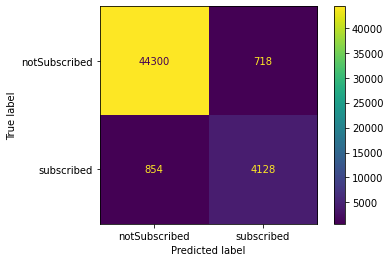

In [0]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predicted_probas = prod_model.predict(X)
predicted_probas[predicted_probas > 0.5] = 1
predicted_probas[predicted_probas <= 0.5] = 0
matrix = confusion_matrix(predicted_probas, y)
fig = ConfusionMatrixDisplay(matrix, display_labels=["notSubscribed", "subscribed"])
fig.plot()

Because the original data is naturally skewed (we get a lot more non-subscribers than we do subscribers) it is normal to see a lot more true positives than true negatives. The number of false positives and false negatives is small compared to that, which is a good sign that our model does exactly what we want and does not overfit too much.

# Part 4: Bringing scored data back into AEP

## 4.a: Create ingestion schema and dataset

In [0]:
from aepp import schema

schema_conn = schema.Schema()

tenant_id = schema_conn.getTenantId()

fieldgroup_res = schema_conn.createFieldGroup({
  	"type": "object",
	"title": f"[CMLE] Fieldgroup for user propensity (created by {username})",
	"description": "This mixin is used to define a propensity score that can be assigned to a given profile.",
	"allOf": [{
		"$ref": "#/definitions/customFields"
	}],
	"meta:containerId": "tenant",
	"meta:resourceType": "mixins",
	"meta:xdmType": "object",
	"definitions": {
      "customFields": {
        "type": "object",
        "properties": {
          f"_{tenant_id}": {
            "type": "object",
            "properties": {
              "propensity": {
                "title": "Propensity",
                "description": "This refers to the propensity of a user towards an outcome.",
                "type": "number"
              },
              "userid": {
                "title": "User ID",
                "description": "This refers to the user having a propensity towards an outcome.",
                "type": "string"
              }
            }
          }
        }
      }
	},
	"meta:intendedToExtend": ["https://ns.adobe.com/xdm/context/profile"]
})

fieldgroup_id = fieldgroup_res["$id"]
fieldgroup_id

Out[259]: 'https://ns.adobe.com/aamds/mixins/4c2c3903adddcae4d1ecc085797880c7132891c1c696563d'

In [0]:
schema_res = schema_conn.createProfileSchema(
  name=f"[CMLE] Schema for user propensity ingestion (created by {username})",
  mixinIds=[
    fieldgroup_id
  ],
  description="Schema generated by CMLE for user propensity score ingestion",
)

schema_id = schema_res["$id"]
schema_alt_id = schema_res["meta:altId"]

print(f"Schema ID: {schema_id}")
print(f"Schema Alt ID: {schema_alt_id}")

Schema ID: https://ns.adobe.com/aamds/schemas/84ee2f12875ea657b20e2379d5ef80c0931b3e38b5d45d60
Schema Alt ID: _aamds.schemas.84ee2f12875ea657b20e2379d5ef80c0931b3e38b5d45d60


In [0]:
descriptor_res = schema_conn.createDescriptor(
  descriptorObj = {
    "@type": "xdm:descriptorIdentity",
    "xdm:sourceSchema": schema_id,
    "xdm:sourceVersion": 1,
    "xdm:sourceProperty": f"/_{tenant_id}/userid",
    "xdm:namespace": identity_type,
    "xdm:property": "xdm:id",
    "xdm:isPrimary": True
  }
)
descriptor_res

Out[263]: {'@id': '9ff7a288c800bc89c157bfcd2f8fb841edffec499edf2a83', '@type': 'xdm:descriptorIdentity', 'xdm:sourceSchema': 'https://ns.adobe.com/aamds/schemas/84ee2f12875ea657b20e2379d5ef80c0931b3e38b5d45d60', 'xdm:sourceVersion': 1, 'xdm:sourceProperty': '/_aamds/userid', 'imsOrg': '36045A905CA640040A495E73@AdobeOrg', 'version': '1', 'xdm:namespace': 'ECID', 'xdm:property': 'xdm:id', 'xdm:isPrimary': True, 'meta:containerId': 'tenant', 'meta:sandboxId': '3cb60f00-e3de-11e9-a3bb-d7c554480df4', 'meta:sandboxType': 'production'}

In [0]:
enable_res = schema_conn.enableSchemaForRealTime(schema_alt_id)
enable_res

Out[261]: {'$id': 'https://ns.adobe.com/aamds/schemas/84ee2f12875ea657b20e2379d5ef80c0931b3e38b5d45d60', 'meta:altId': '_aamds.schemas.84ee2f12875ea657b20e2379d5ef80c0931b3e38b5d45d60', 'meta:resourceType': 'schemas', 'version': '1.1', 'title': '[CMLE] Schema for user propensity ingestion (created by cmenguy@adobe.com)', 'type': 'object', 'description': 'Schema generated by CMLE for user propensity score ingestion', 'allOf': [{'$ref': 'https://ns.adobe.com/xdm/context/profile', 'type': 'object', 'meta:xdmType': 'object'}, {'$ref': 'https://ns.adobe.com/aamds/mixins/4c2c3903adddcae4d1ecc085797880c7132891c1c696563d', 'type': 'object', 'meta:xdmType': 'object'}], 'refs': ['https://ns.adobe.com/xdm/context/profile', 'https://ns.adobe.com/aamds/mixins/4c2c3903adddcae4d1ecc085797880c7132891c1c696563d'], 'imsOrg': '36045A905CA640040A495E73@AdobeOrg', 'additionalInfo': {'numberOfIdentities': 0, 'numberOfRelationShips': 0, 'classTitle': 'XDM Individual Profile', 'behavior': 'Record', 'hasRelati

In [0]:
from aepp import catalog

cat_conn = catalog.Catalog()

ingestion_dataset_res = cat_conn.createDataSets(
  name=f"[CMLE] Dataset for user propensity ingestion (created by {username})",
  schemaId=schema_id
)

ingestion_dataset_id = ingestion_dataset_res[0].split("/")[-1]
ingestion_dataset_id

Out[264]: '63dcc1bd9ce2551c078cf4d1'

In [0]:
# TODO: this is currently failing due to invalid content type, need to fix in aepp, see https://github.com/pitchmuc/aepp/issues/15
# for now just enable in the UI...
cat_conn.enableDatasetProfile(ingestion_dataset_id)

Out[248]: {'type': '/placeholder/type/uri', 'status': 400, 'title': 'BadRequestError', 'detail': 'Content-type does not match json-patch body format, value of Content-type should be application/json-patch+json.'}

## 4.b: Getting new data for scoring

In the previous section we have trained our model using a subset of data. Now that we're ready to use this model for scoring, we need a fresh set of data to score it. It is common to use a much larger set of data for scoring, and we'll be doing the scoring in a distributed manner using data being exported continually from an AEP dataset.

If you haven't already done it in part 3, you need to setup a dataset export.

In [0]:
# TODO: same setup as in 3.b to document here

In [0]:
storage_account_name = "STORAGE_ACCOUNT_NAME"
storage_account_access_key = "YOUR_ACCESS_KEY"

In [0]:
spark.conf.set(
  f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net",
  storage_account_access_key)

file_location = "..."
df_to_score = spark.read.format("csv").option("inferSchema", "true").load(file_location)

In [0]:
# TODO: remove that once we have egress working fully
df_with_user = df[features + ["userId"]].fillna(0)
df_to_score = spark.createDataFrame(df_with_user)

In [0]:
display(df_to_score)

emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_propositionDismiss,minutes_since_linkClick,userId
1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,19175470013282734666488897107602631800
0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,71761114461368081253989339969177281089
0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,28572869501833089771208344917521996452
1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,34918194458045303235426896761830568470
1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,85236016334238178790797841028921755535
1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,66879860573237573247449849548906814900
1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,07278136751886112431565822245130089001
1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,36389135271464589093464109827157580185
0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,77658807558859414298981877358927803118
0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,18168928275706252941415498556714970432


## 4.c: Scoring at scale using production model

In [0]:
import mlflow.pyfunc

top_model_name = "cmle_top_model"
top_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{top_model_name}/production")

2023/02/03 18:22:10 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.
2023/02/03 18:22:11 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
from pyspark.sql.functions import struct
 
# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))
 
df_scored = df_to_score.withColumn(
  "prediction",
  top_model_udf(udf_inputs)
)

In [0]:
from pyspark.sql.functions import udf, col, lit, create_map, array, struct, current_timestamp

from itertools import chain

df_to_ingest = df_scored.select(
  "userId",
  "prediction"
)
df_to_ingest.printSchema()

root
 |-- userId: string (nullable = true)
 |-- prediction: double (nullable = true)



In [0]:
display(df_to_ingest)

userId,prediction
19175470013282734666488897107602631800,0.0018356783810248379
71761114461368081253989339969177281089,0.025292922088901253
28572869501833089771208344917521996452,0.025292922088901253
34918194458045303235426896761830568470,0.0018356783810248379
85236016334238178790797841028921755535,0.0018356783810248379
66879860573237573247449849548906814900,0.0018356783810248379
07278136751886112431565822245130089001,0.0018356783810248379
36389135271464589093464109827157580185,0.0018356783810248379
77658807558859414298981877358927803118,0.025292922088901253
18168928275706252941415498556714970432,0.025292922088901253


## 4.d: Setup ingestion data flow

In [0]:
from aepp import connector

connector = connector.AdobeRequest(
  config_object=aepp.config.config_object,
  header=aepp.config.header,
  loggingEnabled=False,
  logger=None,
)

endpoint = aepp.config.endpoints["global"] + "/data/foundation/connectors/landingzone/credentials"

dlz_credentials = connector.getData(endpoint=endpoint, params={
  "type": "user_drop_zone"
})
dlz_container = dlz_credentials["containerName"]
dlz_sas_token = dlz_credentials["SASToken"]
dlz_storage_account = dlz_credentials["storageAccountName"]
dlz_sas_uri = dlz_credentials["SASUri"]

In [0]:
# These are static values in every org, do not change!
connection_spec_id_source_dlz = "26f526f2-58f4-4712-961d-e41bf1ccc0e8"

In [0]:
from aepp import flowservice

flow_conn = flowservice.FlowService()

In [0]:
source_res = flow_conn.createSourceConnection({
  "name": "Data Landing Zone source connection",
  "data": {
      "format": "delimited"
  },
  "params": {
    "path": f"{dlz_container}/cmle/ingress",
    "type": "folder",
    "recursive": True
  },
  "connectionSpec": {
      "id": connection_spec_id_source_dlz,
      "version": "1.0"
  }
})

source_connection_id = source_res["id"]
source_connection_id

Out[269]: 'bce5c5ac-7a73-4d9e-9ff6-e5a320c887cc'

In [0]:
target_res = flow_conn.createTargetConnectionDataLake(
  name="[CMLE] User Propensity Target Connection",
  datasetId=ingestion_dataset_id,
  schemaId=schema_id
)

target_connection_id = target_res["id"]
target_connection_id

Out[271]: 'dc0102a8-448d-4e90-bcb8-0836168f2e92'

In [0]:
from aepp import dataprep

dataprep_conn = dataprep.DataPrep()

In [0]:
mapping_res = dataprep_conn.createMappingSet(
  schemaId=schema_id,
  validate=True,
  mappingList=[
    {
      "sourceType": "ATTRIBUTE",
      "source": "prediction",
      "destination": f"_{tenant_id}.propensity"
    },
    {
      "sourceType": "ATTRIBUTE",
      "source": "userId",
      "destination": f"_{tenant_id}.userid"
    }
  ]
)

mapping_id = mapping_res["id"]
mapping_id

Out[273]: '50ccaf8511bc41daa8126c07947ad6db'

In [0]:
flow_spec = flow_conn.getFlowSpecs("name==CloudStorageToAEP")
flow_spec_id = flow_spec[0]["id"]
flow_spec_id

Out[277]: '9753525b-82c7-4dce-8a9b-5ccfce2b9876'

In [0]:
import time

flow_res = flow_conn.createFlow({
  "name": "[CMLE] DLZ to AEP for user propensity",
  "flowSpec": {
      "id": flow_spec_id,
      "version": "1.0"
  },
  "sourceConnectionIds": [
      source_connection_id
  ],
  "targetConnectionIds": [
      target_connection_id
  ],
  "transformations": [
      {
          "name": "Mapping",
          "params": {
              "mappingId": mapping_id,
              "mappingVersion": 0
          }
      }
  ],
  "scheduleParams": {
      "startTime": str(int(time.time())),
      "frequency": "minute",
      "interval": "15"
  }
})

dataflow_id = flow_res["id"]
dataflow_id

Out[278]: '51a2aeb2-c48d-4231-ad9f-c139bd1bbb07'

## 4.e: Ingest the scored users into the Unified Profile

In [0]:
spark.conf.set(f"fs.azure.account.auth.type.{dlz_storage_account}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{dlz_storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{dlz_storage_account}.dfs.core.windows.net", dlz_sas_token)

In [0]:
access_path = f"abfss://{dlz_container}@{dlz_storage_account}.dfs.core.windows.net/"
print(access_path)
dbutils.fs.ls(access_path)

abfss://dlz-user-container@dlblobstore14pkfcy2jz1d4.dfs.core.windows.net/
Out[74]: [FileInfo(path='abfss://dlz-user-container@dlblobstore14pkfcy2jz1d4.dfs.core.windows.net/test-cmenguy/', name='test-cmenguy/', size=0, modificationTime=1675450002000)]

In [0]:
df_to_ingest.count()

Out[76]: 50000

In [0]:
import time

protocol = "abfss"
ts = str(int(time.time()))
output_path = f"{protocol}://{dlz_container}@{dlz_storage_account}.dfs.core.windows.net/cmle/ingress/ingest_{unique_id}_{ts}"

df_to_ingest \
  .write \
  .option("header", True) \
  .format("csv") \
  .save(output_path)